<a href="https://colab.research.google.com/github/leohas/ai-project/blob/master/Predi%C3%A7%C3%A3o_de_relev%C3%A2ncia_de_tweets_sobre_o_resultado_do_julgamento_de_Johnny_Depp_x_Amber_Heard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predição de relevância de tweets sobre o resultado do julgamento de Johnny Depp x Amber Heard


Importação de algumas dependências que utilizamos:


*   Pandas
*   Seaborn
*   Matplotlib
*   Joblib



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from joblib import dump, load

**Importação do dataset armazenado no Drive**

O dataset utilizado se chama *Twitter reacts to Johnny DEPP's win*. O mesmo foi encontrado numa busca manual no [Kaggle](https://www.kaggle.com/datasets/towhidultonmoy/twitter-reacts-to-johnny-depps-win-dataset?resource=download) e possui uma ótima qualidade de dados com cerca de 36 colunas relacionadas aos campos que definem a publicação. As colunas utilizadas nessa predição são:

*   **likes_count** - define a quantidade de *likes* da publicação.
*   **tweet** - define o conteúdo da mensagem do tweet.
*   **language** - define a língua do conteúdo da mensagem do tweet.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
csv_file = '../content/gdrive/My Drive/johnny-depp-trial-tweets.csv'
df = pd.read_csv(csv_file)

**Normalização de dados**

Uma normalização de dados se fez necessária pois nossa predição irá considerar apenas tweets com o conteúdo em inglês. Dessa forma, utilizamos da coluna language disponível no dataset para selecionar apenas os artigos de um idioma específico, nesse caso o inglês.

In [ ]:
df = df[df['language'] == 'en']
df['tweet'] = df['tweet'].astype('category')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Ilustração das colunas disponíveis no dataset**

Ao total são 36 colunas disponíveis que definem desde informações relacionadas ao usuário que criou o tweet até o idioma da publicação e a quantidade de curtidas.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7948 entries, 0 to 10003
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   id               7948 non-null   int64   
 1   conversation_id  7948 non-null   int64   
 2   created_at       7948 non-null   object  
 3   date             7948 non-null   object  
 4   time             7948 non-null   object  
 5   timezone         7948 non-null   int64   
 6   user_id          7948 non-null   int64   
 7   username         7948 non-null   object  
 8   name             7948 non-null   object  
 9   place            6 non-null      object  
 10  tweet            7948 non-null   category
 11  language         7948 non-null   object  
 12  mentions         7948 non-null   object  
 13  urls             7948 non-null   object  
 14  photos           7948 non-null   object  
 15  replies_count    7948 non-null   int64   
 16  retweets_count   7948 non-null   int64   

**Ilustração de alguns dados de exemplo**

In [ ]:
df.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1537470110251724801,1537470110251724801,2022-06-16 16:20:13 UTC,2022-06-16,16:20:13,0,1377452573326643203,thatcanongurl,TheCanonGurlTheories,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,1537470081567006720,1537470081567006720,2022-06-16 16:20:06 UTC,2022-06-16,16:20:06,0,1522401491012755457,robynbland567,robyn bland,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,1537470071911632896,1537470071911632896,2022-06-16 16:20:04 UTC,2022-06-16,16:20:04,0,1338250209361600517,n3onrobot,Tyler Datta 🇺🇲 pronouns = Fuck/Off,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,1537470068312915968,1537470068312915968,2022-06-16 16:20:03 UTC,2022-06-16,16:20:03,0,10409622,thedextazlab,David Kisamfu,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
5,1537469964440969217,1537469964440969217,2022-06-16 16:19:38 UTC,2022-06-16,16:19:38,0,3392805053,mshollybennet,Holly Bennet,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


**Definição da função de visualização de dados**

In [ ]:
def plot(df, x='likes_count', title='Likes distribution', xlabel='likes', ylim=100):
    ax = sns.countplot(x=x, data=df)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    for rect in ax.containers[0]:
        tw = rect.get_width() / 2.
        tx = rect.get_x() + tw
        height = rect.get_height()
        ty = 1.05 * height
        ax.text(tx, ty, height, ha='center')

    ax.set_ylim(0, ylim)

**Ilustrando os 50 primeiros dados:**

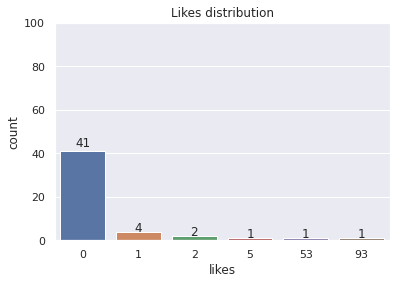

In [ ]:
plot(df[:50])

**Aqui estamos gerando as labels binárias de maneira superficial. No cenário em questão estamos considerando como tweet não relevante aqueles que possuem menos de 100 likes e como tweet relevante aqueles que possuem mais de 100 likes.**

In [ ]:
def generate_labels(df, min_set=None):
    count = df['tweet'].str.len()
    df = df[(count > 3) | (count < 4000)].copy()
    
    if min_set is None:
        min_set = df['likes_count'].value_counts().min() * 4
    
    tweetsWithLessThan100Likes = df[df['likes_count'] <= 100].iloc[:min_set // 2]
    notHypedTweets = pd.concat([tweetsWithLessThan100Likes])
    notHypedTweets['label'] = 0
    
    tweetsWithMoreThan100Likes = df[df['likes_count'] > 100].iloc[:min_set // 2]
    hypedTweets = pd.concat([tweetsWithMoreThan100Likes])
    hypedTweets['label'] = 1
    
    dataset = pd.concat([notHypedTweets, hypedTweets])
    dataset.sort_index(inplace=True)
    
    return dataset

dataset = generate_labels(df,  min_set=50000)

**Aqui está uma ilustração da proporção entre tweets relevantes e não relevantes:**

texts size:  7948
labels size:  7948


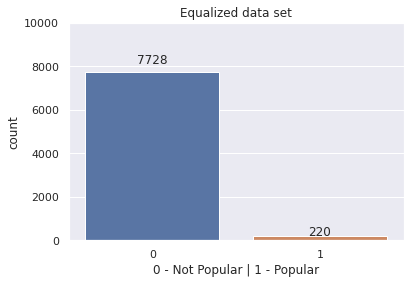

In [ ]:
texts = dataset['tweet'].astype(str)
labels = dataset['label'].astype('int32')

print('texts size: ', texts.size)
print('labels size: ', labels.size)

plot(pd.concat([texts, labels], axis=1), x='label', title='Equalized data set', xlabel='0 - Not Popular | 1 - Popular', ylim=10000)

**Iniciando a definição do modelo:**

In [ ]:
from nltk import word_tokenize
import nltk
import numpy as np

from keras.layers import Embedding
from keras.initializers import Constant
from keras.preprocessing.sequence import pad_sequences

In [ ]:
MAX_NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 400
EMBEDDING_DIM = 100
VALIDATION_SPLIT = .1

In [ ]:
from keras.layers import Dense, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Input
from keras.models import Model
from keras.initializers import Constant

from keras.callbacks import ModelCheckpoint
from keras import backend as K

K.clear_session()

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Definindo a função que irá ler o arquivo de definição de representações semânticas de palavras por meio de vetores. O utilizado é o [GloVe](https://nlp.stanford.edu/projects/glove/) que nos possibilita tratar da maneira ideal os casos de palavras como:



```
Atual: She didn't do that => ['she', 'did', 'nt', 'do', 'that]
Após GloVe: She didn't do that => ['she', 'did', 'not', 'do', 'that]
```



In [ ]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        embeddings_vecs = {}
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, 'f', sep=' ')
            embeddings_vecs[word] = coefs
    
    return embeddings_vecs

In [ ]:
embeddings_vecs = read_glove_vecs('../content/gdrive/My Drive/glove.6B.100d.txt')

print('Foram encontrados %s vetores de palavras.' % len(embeddings_vecs))

Foram encontrados 400000 vetores de palavras.


In [ ]:
from scipy.spatial.distance import cosine

assert "don't" not in embeddings_vecs

word = {}
word["n't"] = embeddings_vecs["n't"]
word["not"] = embeddings_vecs["not"]

print("A similaridade entre %s e %s é %f" % ("n't", "not", 1 - cosine(word["n't"], word["not"])))

A similaridade entre n't e not é 0.901041


**Definindo a função que irá transformar texto em sequência de palavras**

In [ ]:
from keras_preprocessing import text

def _text_to_word_sequence(text, filters='"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True, split=" "):
    text = text.lower()
    
    translate_dict = dict((c, split) for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    
    seq = word_tokenize(text)
    return [i for i in seq if i]

text.text_to_word_sequence = _text_to_word_sequence

tokenizer = text.Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

print('Foram encontrados %s tokens únicos.' % len(word_index))

Foram encontrados 17425 tokens únicos.


In [ ]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
import pprint as pp

pp.pprint(data[0].tolist(), width=200, compact=True)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0

**Definindo a função de pré-treino embedding matrix:**

*   **embeddings_vecs** é um dicionário com palavras e seus respectivos vetores
*   **word_index** é um dicionário com palavras e seus indexes

Obs: Para o caso de palavras que não forem encontradas, será retornado o index 0


In [ ]:
def pretrained_embedding_matrix(embeddings_vecs, word_index):
    """
    embeddings_vecs -- Dicionário com palavras e seus respectivos vetores {word: coefs}
    word_index -- Dicionário com palavras e seus respectivos indexes
    """
    
    num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
    
    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
    
    for word, i in word_index.items():
        if i > MAX_NUM_WORDS:
            break
        embedding_vector = embeddings_vecs.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    
    return embedding_matrix

In [ ]:
embedding_matrix = pretrained_embedding_matrix(embeddings_vecs, word_index)

**Divide os dados entre dados de treino e dados de validação:**

In [ ]:
# Split the date into train and validation sets
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

X_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
X_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

In [ ]:
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('y_train shape:', y_train.shape, 'type', y_train.dtype)
print('y_val shape:', y_val.shape, 'type', y_val.dtype)

X_train shape: (7154, 400)
X_val shape: (794, 400)
y_train shape: (7154,) type int32
y_val shape: (794,) type int32


**Define o modelo utilizando Convolutional Neural Network:**

In [ ]:
from keras.layers import Dense, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Input
from keras.models import Model
from keras.initializers import Constant

from keras.callbacks import ModelCheckpoint
from keras import backend as K

K.clear_session()

In [ ]:
def cnn_model(embedding_matrix):
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

    print(sequence_input)
    
    num_words = embedding_matrix.shape[0]
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                embeddings_initializer=Constant(embedding_matrix),
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False,
                                mask_zero=False) 
    
    embedded_sequences = embedding_layer(sequence_input)
    
    X = Conv1D(128, 5, activation='relu')(embedded_sequences)
    X = MaxPooling1D(5)(X)
    X = Conv1D(128, 5, activation='relu')(X)
    X = MaxPooling1D(5)(X)
    X = Conv1D(128, 5, activation='relu')(X)
    X = GlobalMaxPooling1D()(X)
    X = Dense(128, activation='relu')(X)
    preds = Dense(1, activation='sigmoid')(X)

    model = Model(sequence_input, preds)
    
    return model

In [ ]:
model = cnn_model(embedding_matrix)
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 400), dtype=tf.int32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400)]             0         
                                                                 
 embedding (Embedding)       (None, 400, 100)          1742600   
                                                                 
 conv1d (Conv1D)             (None, 396, 128)          64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 79, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 75, 128)           82048     
                                                  

**Compila o modelo e realizar o fit:**

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
%%time

history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=15,
                    validation_data=(X_val, y_val))

Epoch 1/15
56/56 [==============================] - 14s 34ms/step - loss: 0.1579 - accuracy: 0.9704 - val_loss: 0.1105 - val_accuracy: 0.9786
Epoch 2/15
56/56 [==============================] - 1s 12ms/step - loss: 0.1236 - accuracy: 0.9716 - val_loss: 0.1034 - val_accuracy: 0.9786
Epoch 3/15
56/56 [==============================] - 1s 12ms/step - loss: 0.1178 - accuracy: 0.9716 - val_loss: 0.0972 - val_accuracy: 0.9786
Epoch 4/15
56/56 [==============================] - 1s 12ms/step - loss: 0.1027 - accuracy: 0.9716 - val_loss: 0.0993 - val_accuracy: 0.9786
Epoch 5/15
56/56 [==============================] - 1s 13ms/step - loss: 0.0855 - accuracy: 0.9727 - val_loss: 0.1308 - val_accuracy: 0.9736
Epoch 6/15
56/56 [==============================] - 1s 12ms/step - loss: 0.0601 - accuracy: 0.9778 - val_loss: 0.1540 - val_accuracy: 0.9786
Epoch 7/15
56/56 [==============================] - 1s 12ms/step - loss: 0.0470 - accuracy: 0.9832 - val_loss: 0.1708 - val_accuracy: 0.9786
Epoch 8/15
5

**Ilustra os resultados graficamente:**

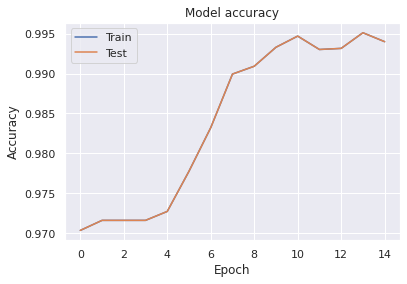

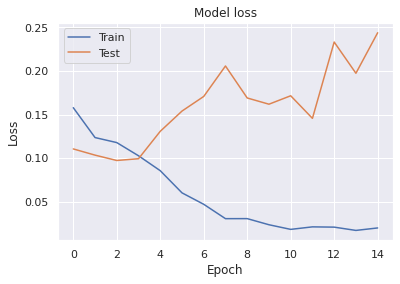

In [ ]:
def plot_results(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

plot_results(history)